# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym_walk

from tqdm import tqdm

# Define Functions

## Function: gen_episode

In [2]:
def gen_episode(env, policy):
    
    '''
    Generate one episode of agent-environment interaction
    Arguments:
        env: Instance of environment to use for generating episode
        policy: Policy to use for generating episode
        
    Returns:
        states_list: List of states encountered in the episode (includes init_state and term_state)
        actions_list: List of actions take by agent at each time step
        rewards_list: List of rewards received by agent at each time step
    '''
    
    states_list = [] # Placeholder to store list of all states encountered in episode
    actions_list = [] # Placeholder to store list of all actions taken by agent
    rewards_list = [] # Placeholder to store list of rewards received at each step

    
    env.reset() # Reset environment
    curr_state = env.s # Obtain initial starting state (S)
    states_list.append(curr_state) # Update states_list with initial state    
    while (True): # Run agent till terminal states are reached
        action = policy(curr_state) # Generate action according to current policy
        next_state, reward, is_done, _ = env.step(action) # Take action and obtain R, S'    
        states_list.append(next_state) # Update states_list
        actions_list.append(action) # Update actions_list
        rewards_list.append(reward) # Update rewards list
        
        # Stop episode if terminal state has been reached
        if (is_done): 
            break
            
    return states_list, actions_list, rewards_list      

## Function: const_alpha_mc_prediction

In [3]:
def const_alpha_mc_prediction(env, policy, svf_init, num_episodes, alpha, discount_factor = 1.0, visit_type = 'every'):
    
    '''
    Function to run MC prediction and estimate state value function for a given policy
    Arguments:
        env: Instance of environment to use for MC prediction
        policy: Policy to evaluate
        svf_init: Initial state-value function        
        num_episodes: Number of episodes to use for MC prediction algorithm
        alpha: Learning Rate
        discount_factor: Discounting factor for reward computation
        visit_type: 'first' for first-visit MC prediction,
                    'every' for every-visit MC prediction.
        
    Returns:
        svf: Final state-value function
        state_count: Number of times each state is encountered during MC prediction
    '''
    
    svf = svf_init.copy() # Initialize state-value function    
    state_count = np.zeros(svf.shape)
    
    # Loop through 'num_episodes' episodes
    for ep in range(num_episodes):
        ep_states, ep_actions, ep_rewards = gen_episode(env, policy) # Generate one episode
        num_timesteps = len(ep_rewards) # Number of timesteps in current episode
        G = 0 # Initialize return to 0
        
        # Loop through each timestep of current episode
        for ind in range((num_timesteps - 1), -1, -1): 
            G = discount_factor * G + ep_rewards[ind] # Update return of current timestep
            curr_state = ep_states[ind] # Retrieve state of current timestep
            curr_action = ep_actions[ind] # Retrieve action of current timestep
            curr_st_act = str(curr_state) + '_' + str(curr_action)
            if (visit_type == 'first'): # For first-visit MC prediction
                if (curr_state not in ep_states[0:ind]):
                    svf[curr_state] += alpha * (G - svf[curr_state])
            elif (visit_type == 'every'): # For every-visit MC prediction
                #st_act_count[curr_st_act] += 1
                svf[curr_state] += alpha * (G - svf[curr_state])
                #avpi[curr_st_act] += (G - avpi[curr_st_act]) / st_act_count[curr_st_act]
                
        
    return svf, state_count

## Function: td0_prediction

In [4]:
def td0_prediction(env, policy, svf_init, num_episodes, discount_factor = 1.0, alpha = 0.5):
    """
    Tabular TD(0) algorithm.
    Ref: Section 6.1, Pg. 120 of RL_Sutton
    
    Args:
        env: OpenAI environment.
        policy: Policy to be evaluated
        svf_init: Initial state-value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
    
    Returns:
        svf: Final state-value function
    """
    
    svf = svf_init.copy() # Initialize state-value function

    for ep in range(num_episodes): # Iterate through num_episodes
        env.reset() # Reset environment
        curr_state = env.s # Obtain initial starting state (S)
        while (True):
            action = policy(curr_state) # Generate action according to current policy
            next_state, reward, is_done, _ = env.step(action) # Take action and obtain R, S'

            # Perform TD(0) update
            td_target = reward + discount_factor * svf[next_state]
            td_delta = td_target - svf[curr_state]
            svf[curr_state] += alpha * td_delta

            curr_state = next_state # S <-- S'

            if (is_done):
                break   
    
    return svf

# Initialize Environment

In [5]:
env = gym.make('WalkFive-v0')

# Example 6.2 - Random Walk - Part A

Plot learnt value function vs. true value fuction for TD(0) (alpha = 0.1) for different episode lengths

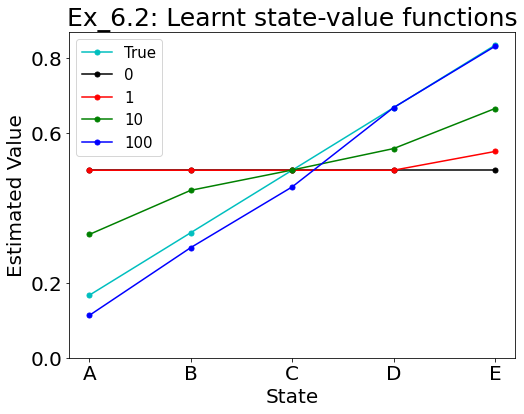

In [6]:
policy = lambda x: np.random.choice([0, 1]) # Random equiprobable policy
num_states = 7 # Number of states in random walk (2 terminal states)
num_ep_list = [1, 10, 100] # Number of episodes in each run
color_list = ['r', 'g', 'b']

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

# Initialize state value function
svf_init = np.zeros(num_states)
svf_init[1:(num_states-1)] = 0.5

plt.figure(figsize = (8, 6))
plt.plot(tvf, color = 'c', label = 'True', marker = '.', ms = 10.0)
plt.plot(svf_init[1:6], color = 'k', label = '0', marker = '.', ms = 10.0)

for ind, num_ep in enumerate(num_ep_list): # Iterate through num_ep_list
    # Run TD(0) algorithm
    svf = td0_prediction(env, policy, svf_init, num_ep, discount_factor = 1.0, alpha = 0.1)
    plt.plot(svf[1:6], label = str(num_ep), color = color_list[ind], marker = '.', ms = 10.0)

plt.title("Ex_6.2: Learnt state-value functions", fontsize = 25)
plt.xlabel("State", fontsize = 20)
plt.ylabel("Estimated Value", fontsize = 20)
plt.xticks(ticks = [0, 1, 2, 3, 4], labels = ['A', 'B', 'C', 'D', 'E'], fontsize = 20)
plt.yticks(ticks = [0, 0.2, 0.6, 0.8], fontsize = 20)
plt.legend(fontsize = 15)
plt.show()

# Example 6.2 - Random Walk - Part B

Empirical RMSE vs. number of episodes for TD(0) and constant-alpha MC

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:15<00:00,  1.47s/it]


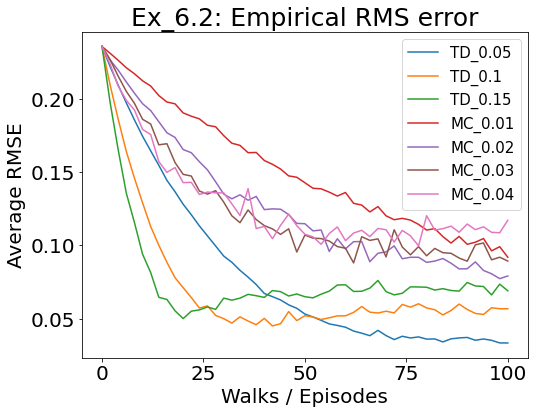

In [12]:
policy = lambda x: np.random.choice([0, 1]) # Random equiprobable policy
num_states = 7 # Number of states in random walk (2 terminal states)
num_runs = 100 # Number of runs to average over
ep_max = 101
ep_step = 2

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

# Initialize state value function
svf_init = np.zeros(num_states)
svf_init[1:(num_states-1)] = 0.5

plt.figure(figsize = (8, 6))
plt.title("Ex_6.2: Empirical RMS error", fontsize = 25)
plt.xlabel("Walks / Episodes", fontsize = 20)
plt.ylabel("Average RMSE", fontsize = 20)
plt.xticks(ticks = [0, 25, 50, 75, 100], fontsize = 20)
plt.yticks(ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize = 20)

alpha_array_td = [0.05, 0.1, 0.15] # List of alpha values to use for TD(0)
for alpha in alpha_array_td: # Iterate through each alpha value
    rmse_td_array = [] # Placeholder to store average rmse for different episode lengths
    num_ep_array = [] # Placeholder to store  episode lengths
    for num_ep in tqdm(range(0, ep_max, ep_step)): # Loop through different episode lengths
        if (num_ep > 0):
            rmse_td = 0
            for run in range(num_runs): # Iterate through num_runs
                # Run TD(0) algorithm            
                svf_td = td0_prediction(env, policy, svf_init, num_ep, discount_factor = 1.0, alpha = alpha)
                rmse_td += np.sqrt(np.mean((tvf - svf_td[1:6]) ** 2)) # Update rmse with current run
            rmse_td /= num_runs # Average rmse over all runs
        else:
            rmse_td = np.sqrt(np.mean((tvf - svf_init[1:6]) ** 2))
        rmse_td_array.append(rmse_td)
        num_ep_array.append(num_ep)
    plt.plot(num_ep_array, rmse_td_array, label = ('TD_' + str(alpha)))


alpha_array_mc = [0.01, 0.02, 0.03, 0.04] # List of alpha values to use for constant-alpha MC
for alpha in alpha_array_mc: # Iterate through each alpha value
    rmse_mc_array = [] # Placeholder to store average rmse for different episode lengths
    num_ep_array = [] # Placeholder to store  episode lengths
    for num_ep in tqdm(range(0, ep_max, ep_step)): # Loop through different episode lengths
        if (num_ep > 0):
            rmse_mc = 0
            for run in range(num_runs): # Iterate through num_runs
                # Run Const-alpha MC algorithm
                svf_mc, _ = const_alpha_mc_prediction(env, policy, svf_init, num_ep, alpha, 1.0, visit_type = 'every')
                rmse_mc += np.sqrt(np.mean((tvf - svf_mc[1:6]) ** 2))
            rmse_mc /= num_runs
        else:
            rmse_mc = np.sqrt(np.mean((tvf - svf_init[1:6]) ** 2))
        rmse_mc_array.append(rmse_mc)
        num_ep_array.append(num_ep)    
    plt.plot(num_ep_array, rmse_mc_array, label = ('MC_' + str(alpha)))

plt.legend(fontsize = 15)
plt.show()

# Backup - Environment Details

In [8]:
print("Environment State Mapping")
print("-------------------------")
print("0  1  2  3  4  5  6  7  8  9  10 11")
print("12 13 14 15 16 17 18 19 20 21 22 23")
print("24 25 26 27 28 29 30 31 32 33 34 35")
print("36 37 38 39 40 41 42 43 44 45 46 47")
print()
print()
print("Start State: 36, Goal State: 47")
print()
print()
print("Cliff States")
print("------------")
print("37 38 39 40 41 42 43 44 45 46 47")
print()
print("Actions")
print("-------")
print("0: Up")
print("1: Right")
print("2: Down")
print("3: Left")

Environment State Mapping
-------------------------
0  1  2  3  4  5  6  7  8  9  10 11
12 13 14 15 16 17 18 19 20 21 22 23
24 25 26 27 28 29 30 31 32 33 34 35
36 37 38 39 40 41 42 43 44 45 46 47


Start State: 36, Goal State: 47


Cliff States
------------
37 38 39 40 41 42 43 44 45 46 47

Actions
-------
0: Up
1: Right
2: Down
3: Left


In [9]:
env.reset()
print("Action_Space:", env.action_space)
print("Number of Actions:", env.nA)
print("Number of States:", env.nS)
print("Observation_Space:", env.observation_space)
print("Env. shape:", env.shape)
print("Start State Index:", env.start_state_index)

Action_Space: Discrete(2)
Number of Actions: 2
Number of States: 7
Observation_Space: Discrete(7)
Env. shape: (1, 7)
Start State Index: 3


In [10]:
# Sample trajectories
env.reset()
print(env.s, end = ', ')

env.step(0)
print("Left -->", env.s, end = ", ")

env.step(0)
print("Left -->", env.s, end = ", ")

env.step(0)
print("Left -->", env.s, end = ", ")

env.step(0)
print("Left -->", env.s, end = ", ")

print()
env.reset()
print(env.s, end = ', ')

env.step(1)
print("Right -->", env.s, end = ", ")

env.step(1)
print("Right -->", env.s, end = ", ")

env.step(1)
print("Right -->", env.s, end = ", ")

env.step(1)
print("Right -->", env.s, end = ", ")

3, Left --> 2, Left --> 1, Left --> 0, Left --> 0, 
3, Right --> 4, Right --> 5, Right --> 6, Right --> 6, 